# pix2pix - segmentation

元論文 : Image-to-Image Translation with Conditional Adversarial Networks https://arxiv.org/abs/1611.07004 (2016)

pix2pixは画素（pixel)と画素の関係を学習させる。


In [1]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [6]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *
from pprint import pprint
from torchsummary import summary

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = OrderedDict({
    'background' : [0, 0, 0],
    'akahara' : [128, 0, 0],
    'madara' : [0, 128, 0]
      }) # list, dict('label' : '[R, G, B]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 64
cfg.INPUT_WIDTH = 64
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB'

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = cfg.CLASS_NUM
cfg.OUTPUT_MODE = 'CLASS_LABEL'  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = None # pyplot cmap

cfg.G_DIM = 32
cfg.D_DIM = 32

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'pix2pix'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 8
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}


cfg.TRAIN.DATA_PATH = '../../Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# pix2pix  config
#---
cfg.PIX2PIX_LAMBDA = 10


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '../../Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': {'akahara': [128, 0, 0],
                 'background': [0, 0, 0],
                 'madara': [0, 128, 0]},
 'CLASS_NUM': 3,
 'DEVICE': device(type='cpu'),
 'D_DIM': 32,
 'GPU': False,
 'G_DIM': 32,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 64,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 64,
 'OUTPUT_CHANNEL': 3,
 'OUTPUT_CMAP': None,
 'OUTPUT_HEIGHT': 64,
 'OUTPUT_MODE': 'CLASS_LABEL',
 'OUTPUT_WIDTH': 64,
 'PIX2PIX_LAMBDA': 10,
 'PREFIX': 'pix2pix',
 'TEST': {'DATA_PATH': '../../Dataset/test/images/',
          'ITERATION': 2,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/pix2pix_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/pix2pix_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': True,
           'DATA_PATH': '../../Dataset/train/images/',
           'DATA_ROTATION': 1,
           'DATA_VERTICAL_FLIP': True,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 10000,
           'LEARNING

## Define Model

In [7]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
    
class Encoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name, stack_num=2):
        super(Encoder_block, self).__init__()
        _module = OrderedDict()
        for i in range(stack_num):
            f = dim1 if i == 0 else dim2
            _module['{}_stack_{}_conv'.format(name, i  + 1)] = torch.nn.Conv2d(f, dim2, kernel_size=3, padding=1, stride=1)
            _module['{}_stack_{}_act'.format(name, i + 1)] = torch.nn.ReLU()
            _module['{}_stack_{}_bn'.format(name, i + 1)] = torch.nn.BatchNorm2d(dim2)
            
        self.module = torch.nn.Sequential(_module)

    def forward(self, x):
        return self.module(x)

class Decoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name):
        super(Decoder_block, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            '{}_transConv'.format(name) : torch.nn.ConvTranspose2d(dim1, dim2, kernel_size=2, stride=2),
            '{}_bn'.format(name) : torch.nn.BatchNorm2d(dim2)
        }))

    def forward(self, x):
        return self.module(x)

    
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        dim = cfg.G_DIM
        
        self.encoders = torch.nn.ModuleList([
            Encoder_block(cfg.INPUT_CHANNEL, dim, name='G_encoder_1'), 
            Encoder_block(dim, dim * 2, name='G_encoder_2'),
            Encoder_block(dim * 2, dim * 4, name='G_encoder_3'),
            Encoder_block(dim * 4, dim * 8, name='G_encoder_4'),
            Encoder_block(dim * 8, dim * 16, name='G_encoder_5'),
            Encoder_block(dim * 16, dim * 16, name='G_encoder_6'),
        ])
        
        self.decoders = torch.nn.ModuleList([
            Encoder_block(dim * 16, dim * 16, name='G_decoder_5'),
            Encoder_block(dim * 32, dim * 8, name='G_decoder_4'),
            Encoder_block(dim * 16, dim * 4, name='G_decoder_3'),
            Encoder_block(dim * 8, dim * 2, name='G_decoder_2'),
            Encoder_block(dim * 4, dim, name='G_decoder_1'),
        ])
            
        self.out = torch.nn.Sequential(OrderedDict({
            'G_out' : torch.nn.Conv2d(dim, cfg.OUTPUT_CHANNEL, kernel_size=3, padding=1, stride=1),
            'G_out_act' : torch.nn.Tanh()
        }))

        
    def forward(self, x):
        outputs = []
        # encoder
        for encoder in self.encoders[:-1]:
            x = encoder(x)
            outputs.append(x)
            x = F.max_pool2d(x, 2, stride=2, padding=0)
        
        x = self.encoders[-1](x)
        
        # decoder
        for i, decoder in enumerate(self.decoders[:-1]):
            x = decoder(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = torch.cat([x, outputs[ - i - 1]], dim=1)
        
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.decoders[-1](x)
        return self.out(x)
        

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        dim = cfg.D_DIM
        
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_conv' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, dim, kernel_size=5, padding=2, stride=2),
            'D_layer_1_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_2_conv' : torch.nn.Conv2d(dim, dim * 2, kernel_size=5, padding=2, stride=2),
            'D_layer_2_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_3_conv' : torch.nn.Conv2d(dim * 2, dim * 4, kernel_size=5, padding=2, stride=2),
            'D_layer_3_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_4_conv' : torch.nn.Conv2d(dim * 4, dim * 8, kernel_size=5, padding=2, stride=2),
            'D_layer_4_act' : torch.nn.LeakyReLU(0.2),
            #'D_out' : torch.nn.Conv2d(dim * 8, 1, kernel_size=cfg.OUTPUT_HEIGHT // 16, padding=0, stride=1),
            'D_flatten' : Flatten(),
            'D_out' : torch.nn.Linear((cfg.OUTPUT_HEIGHT // 16) * (cfg.OUTPUT_WIDTH // 16) * dim * 8, 1),
            'D_out_act' : torch.nn.Sigmoid()
        }))
        
    def forward(self, x):
        return self.module(x)
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Utility

In [8]:
def result_show(G, Xs, path=None, save=False, show=False,  figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    Gz = G(Xs)
    Gz = Gz.detach().cpu().numpy()
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(Gz))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _G = Gz[i]
        _G = _G.argmax(axis=0)
        out = np.zeros([cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, 3], dtype=np.uint8)
        for j, (label, pix) in enumerate(cfg.CLASS_LABEL.items()):
            out[_G == j] = pix
            
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(out, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

100%|██████████| 16/16 [00:00<00:00, 3990.06it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
     Encoder_block-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
              ReLU-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
    Encoder_block-14           [-1, 64,

Iter:50, LossG:2.4533 (fake:0.0001, L1:2.4531), LossD:0.0002 (real:0.0000, fake:0.0001)
Iter:100, LossG:1.9075 (fake:0.0000, L1:1.9075), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:150, LossG:1.8354 (fake:0.0000, L1:1.8354), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:200, LossG:1.5401 (fake:0.0000, L1:1.5401), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter200.pt, D >> models/pix2pix_D_iter200.pt
Iter:250, LossG:1.6098 (fake:0.0000, L1:1.6098), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:300, LossG:1.2346 (fake:0.0000, L1:1.2346), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:350, LossG:1.1102 (fake:0.0000, L1:1.1102), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:400, LossG:1.2032 (fake:0.0000, L1:1.2032), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter400.pt, D >> models/pix2pix_D_iter400.pt
Iter:450, LossG:1.2012 (fake:0.0000, L1:1.2012), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:500, LossG:1.0437 (fake:0.0000, L1:1.0437), LossD:0

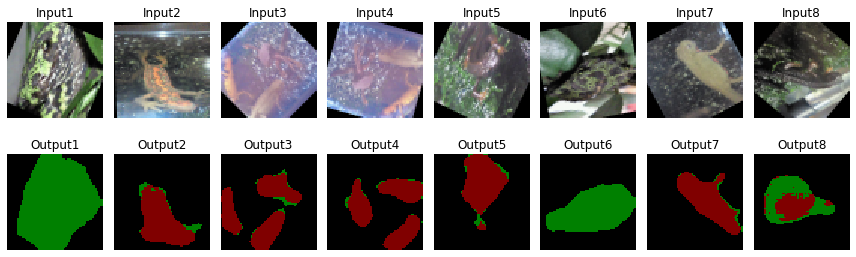

Iter:550, LossG:1.7651 (fake:0.0000, L1:1.7651), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:600, LossG:0.9099 (fake:0.0000, L1:0.9099), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter600.pt, D >> models/pix2pix_D_iter600.pt
Iter:650, LossG:0.9680 (fake:0.0000, L1:0.9680), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:700, LossG:0.9897 (fake:0.0000, L1:0.9897), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:750, LossG:1.1041 (fake:0.0000, L1:1.1041), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:800, LossG:1.0530 (fake:0.0000, L1:1.0530), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter800.pt, D >> models/pix2pix_D_iter800.pt
Iter:850, LossG:0.8743 (fake:0.0000, L1:0.8743), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:900, LossG:0.9764 (fake:0.0000, L1:0.9764), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:950, LossG:0.8473 (fake:0.0000, L1:0.8473), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1000, LossG:0.9704 (fake:0.0000, L1:0.9704), LossD

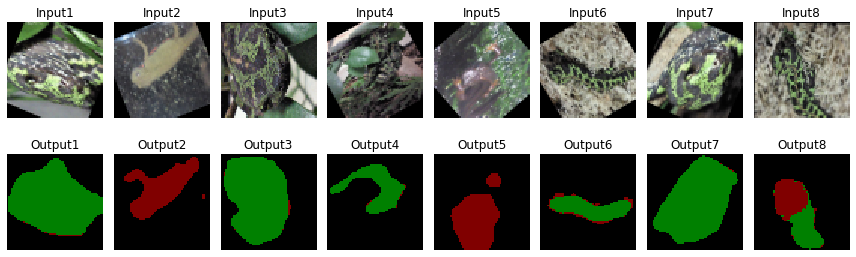

Iter:1050, LossG:0.8100 (fake:0.0000, L1:0.8100), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1100, LossG:0.8958 (fake:0.0000, L1:0.8958), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1150, LossG:0.9931 (fake:0.0000, L1:0.9931), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1200, LossG:0.8894 (fake:0.0000, L1:0.8894), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1200.pt, D >> models/pix2pix_D_iter1200.pt
Iter:1250, LossG:1.0499 (fake:0.0000, L1:1.0499), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1300, LossG:0.8578 (fake:0.0000, L1:0.8578), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1350, LossG:1.0323 (fake:0.0000, L1:1.0323), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1400, LossG:0.7737 (fake:0.0000, L1:0.7737), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1400.pt, D >> models/pix2pix_D_iter1400.pt
Iter:1450, LossG:0.8702 (fake:0.0000, L1:0.8702), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1500, LossG:0.8026 (fake:0.0000, L1:0

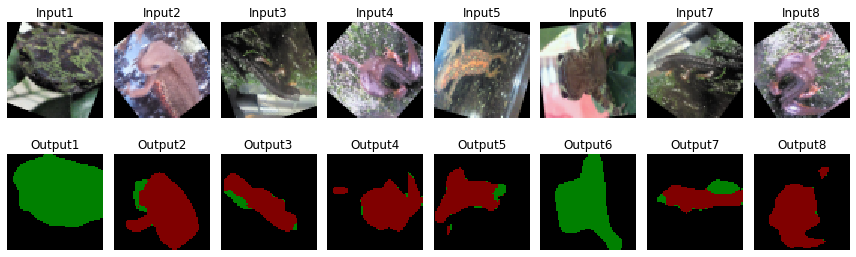

Iter:1550, LossG:0.6772 (fake:0.0000, L1:0.6772), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1600, LossG:0.8135 (fake:0.0000, L1:0.8135), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1600.pt, D >> models/pix2pix_D_iter1600.pt
Iter:1650, LossG:0.7639 (fake:0.0000, L1:0.7639), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1700, LossG:0.8365 (fake:0.0000, L1:0.8365), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1750, LossG:0.6968 (fake:0.0000, L1:0.6968), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1800, LossG:0.5724 (fake:0.0000, L1:0.5724), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1800.pt, D >> models/pix2pix_D_iter1800.pt
Iter:1850, LossG:0.7531 (fake:0.0000, L1:0.7531), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1900, LossG:0.6504 (fake:0.0000, L1:0.6504), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1950, LossG:0.5612 (fake:0.0000, L1:0.5612), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2000, LossG:0.8291 (fake:0.0000, L1:0

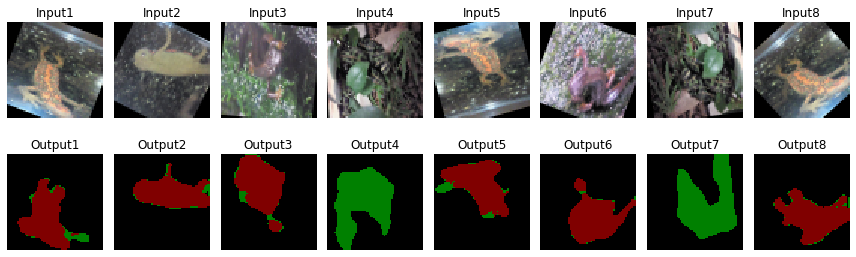

Iter:2050, LossG:0.5461 (fake:0.0000, L1:0.5461), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2100, LossG:0.5807 (fake:0.0000, L1:0.5807), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2150, LossG:0.6687 (fake:0.0000, L1:0.6687), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2200, LossG:1.0889 (fake:0.0000, L1:1.0889), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2200.pt, D >> models/pix2pix_D_iter2200.pt
Iter:2250, LossG:0.7176 (fake:0.0000, L1:0.7176), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2300, LossG:0.6578 (fake:0.0000, L1:0.6578), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2350, LossG:0.6404 (fake:0.0000, L1:0.6404), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2400, LossG:0.7544 (fake:0.0000, L1:0.7544), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2400.pt, D >> models/pix2pix_D_iter2400.pt
Iter:2450, LossG:0.6329 (fake:0.0000, L1:0.6329), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2500, LossG:0.5228 (fake:0.0000, L1:0

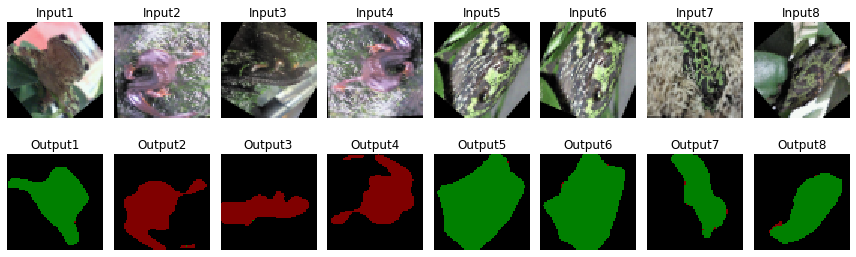

Iter:2550, LossG:0.5738 (fake:0.0000, L1:0.5738), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2600, LossG:0.5784 (fake:0.0000, L1:0.5784), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2600.pt, D >> models/pix2pix_D_iter2600.pt
Iter:2650, LossG:0.5387 (fake:0.0000, L1:0.5387), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2700, LossG:0.5628 (fake:0.0000, L1:0.5628), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2750, LossG:0.5778 (fake:0.0000, L1:0.5778), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2800, LossG:0.7145 (fake:0.0000, L1:0.7145), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2800.pt, D >> models/pix2pix_D_iter2800.pt
Iter:2850, LossG:0.4916 (fake:0.0000, L1:0.4916), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2900, LossG:0.5825 (fake:0.0000, L1:0.5825), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2950, LossG:0.6001 (fake:0.0000, L1:0.6001), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3000, LossG:0.5376 (fake:0.0000, L1:0

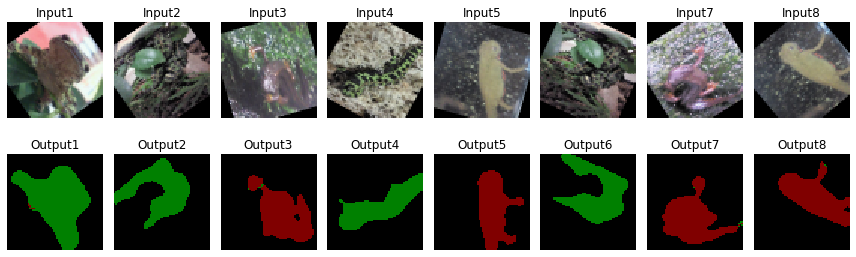

Iter:3050, LossG:0.4914 (fake:0.0000, L1:0.4914), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3100, LossG:0.4231 (fake:0.0000, L1:0.4231), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3150, LossG:0.6162 (fake:0.0000, L1:0.6162), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3200, LossG:0.5627 (fake:0.0000, L1:0.5627), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3200.pt, D >> models/pix2pix_D_iter3200.pt
Iter:3250, LossG:0.5788 (fake:0.0000, L1:0.5788), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3300, LossG:0.5363 (fake:0.0000, L1:0.5363), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3350, LossG:0.5753 (fake:0.0000, L1:0.5753), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3400, LossG:0.4823 (fake:0.0000, L1:0.4823), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3400.pt, D >> models/pix2pix_D_iter3400.pt
Iter:3450, LossG:0.5618 (fake:0.0000, L1:0.5618), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3500, LossG:0.4647 (fake:0.0000, L1:0

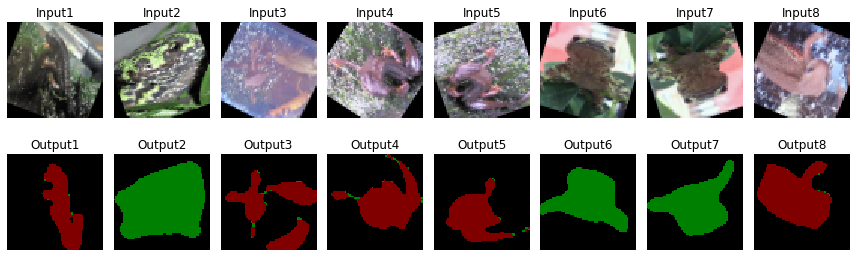

Iter:3550, LossG:0.7640 (fake:0.0000, L1:0.7640), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3600, LossG:0.4516 (fake:0.0000, L1:0.4516), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3600.pt, D >> models/pix2pix_D_iter3600.pt
Iter:3650, LossG:0.5150 (fake:0.0000, L1:0.5150), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3700, LossG:0.5123 (fake:0.0000, L1:0.5123), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3750, LossG:0.4799 (fake:0.0000, L1:0.4799), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3800, LossG:0.4449 (fake:0.0000, L1:0.4449), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3800.pt, D >> models/pix2pix_D_iter3800.pt
Iter:3850, LossG:0.5020 (fake:0.0000, L1:0.5020), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3900, LossG:0.6187 (fake:0.0000, L1:0.6187), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3950, LossG:0.4408 (fake:0.0000, L1:0.4408), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4000, LossG:0.4254 (fake:0.0000, L1:0

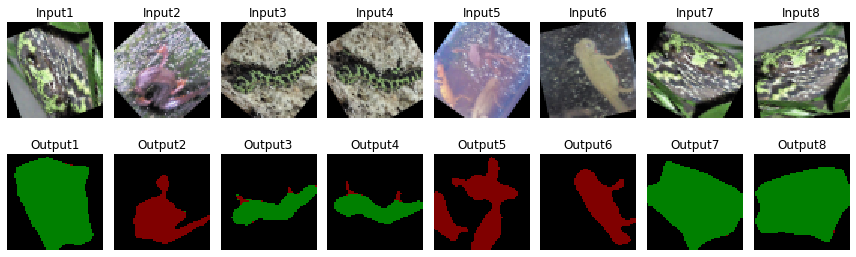

Iter:4050, LossG:0.4361 (fake:0.0000, L1:0.4361), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4100, LossG:0.6042 (fake:0.0000, L1:0.6042), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4150, LossG:0.5548 (fake:0.0000, L1:0.5548), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4200, LossG:0.5046 (fake:0.0000, L1:0.5046), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4200.pt, D >> models/pix2pix_D_iter4200.pt
Iter:4250, LossG:0.3973 (fake:0.0000, L1:0.3973), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4300, LossG:0.5902 (fake:0.0000, L1:0.5902), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4350, LossG:0.4802 (fake:0.0000, L1:0.4802), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4400, LossG:0.4650 (fake:0.0000, L1:0.4650), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4400.pt, D >> models/pix2pix_D_iter4400.pt
Iter:4450, LossG:0.5109 (fake:0.0000, L1:0.5109), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4500, LossG:0.7782 (fake:0.0000, L1:0

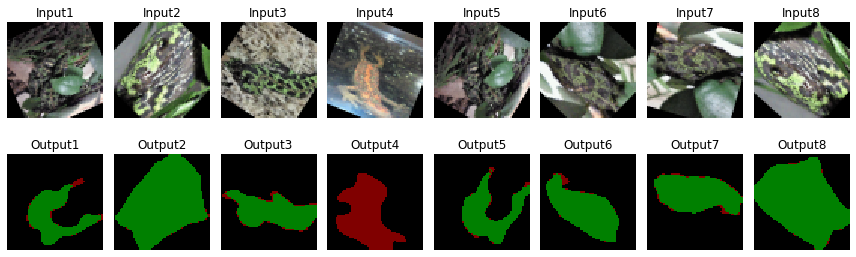

Iter:4550, LossG:0.5666 (fake:0.0000, L1:0.5666), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4600, LossG:0.4668 (fake:0.0000, L1:0.4668), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4600.pt, D >> models/pix2pix_D_iter4600.pt
Iter:4650, LossG:0.5844 (fake:0.0000, L1:0.5844), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4700, LossG:0.5039 (fake:0.0000, L1:0.5039), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4750, LossG:0.4333 (fake:0.0000, L1:0.4333), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4800, LossG:0.5455 (fake:0.0000, L1:0.5455), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4800.pt, D >> models/pix2pix_D_iter4800.pt
Iter:4850, LossG:0.5445 (fake:0.0000, L1:0.5445), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4900, LossG:0.5811 (fake:0.0000, L1:0.5811), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4950, LossG:0.3912 (fake:0.0000, L1:0.3912), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5000, LossG:0.4828 (fake:0.0000, L1:0

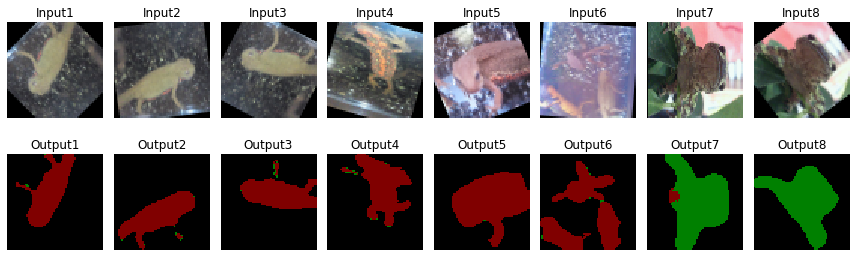

Iter:5050, LossG:0.4162 (fake:0.0000, L1:0.4162), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5100, LossG:0.4788 (fake:0.0000, L1:0.4788), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5150, LossG:0.4209 (fake:0.0000, L1:0.4209), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5200, LossG:0.4553 (fake:0.0000, L1:0.4553), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5200.pt, D >> models/pix2pix_D_iter5200.pt
Iter:5250, LossG:0.4507 (fake:0.0000, L1:0.4507), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5300, LossG:0.4620 (fake:0.0000, L1:0.4620), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5350, LossG:0.5142 (fake:0.0000, L1:0.5142), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5400, LossG:0.4171 (fake:0.0000, L1:0.4171), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5400.pt, D >> models/pix2pix_D_iter5400.pt
Iter:5450, LossG:0.4620 (fake:0.0000, L1:0.4620), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5500, LossG:0.5696 (fake:0.0000, L1:0

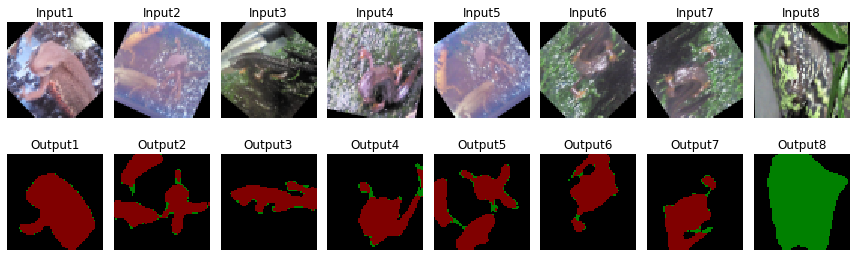

Iter:5550, LossG:0.3990 (fake:0.0000, L1:0.3990), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5600, LossG:0.3953 (fake:0.0000, L1:0.3953), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5600.pt, D >> models/pix2pix_D_iter5600.pt
Iter:5650, LossG:0.6181 (fake:0.0000, L1:0.6181), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5700, LossG:0.4814 (fake:0.0000, L1:0.4814), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5750, LossG:0.4956 (fake:0.0000, L1:0.4956), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5800, LossG:0.3913 (fake:0.0000, L1:0.3913), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5800.pt, D >> models/pix2pix_D_iter5800.pt
Iter:5850, LossG:0.3934 (fake:0.0000, L1:0.3934), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5900, LossG:0.3773 (fake:0.0000, L1:0.3773), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5950, LossG:0.4113 (fake:0.0000, L1:0.4113), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6000, LossG:0.4498 (fake:0.0000, L1:0

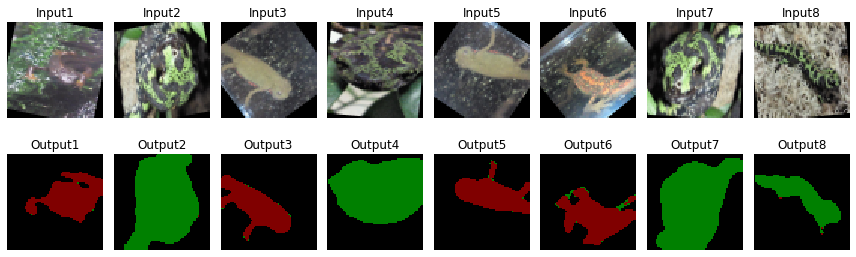

Iter:6050, LossG:0.3988 (fake:0.0000, L1:0.3988), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6100, LossG:0.3513 (fake:0.0000, L1:0.3513), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6150, LossG:0.4477 (fake:0.0000, L1:0.4477), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6200, LossG:0.3948 (fake:0.0000, L1:0.3948), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6200.pt, D >> models/pix2pix_D_iter6200.pt
Iter:6250, LossG:0.5012 (fake:0.0000, L1:0.5012), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6300, LossG:0.3850 (fake:0.0000, L1:0.3850), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6350, LossG:0.4605 (fake:0.0000, L1:0.4605), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6400, LossG:0.3815 (fake:0.0000, L1:0.3815), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6400.pt, D >> models/pix2pix_D_iter6400.pt
Iter:6450, LossG:0.4007 (fake:0.0000, L1:0.4007), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6500, LossG:0.5862 (fake:0.0000, L1:0

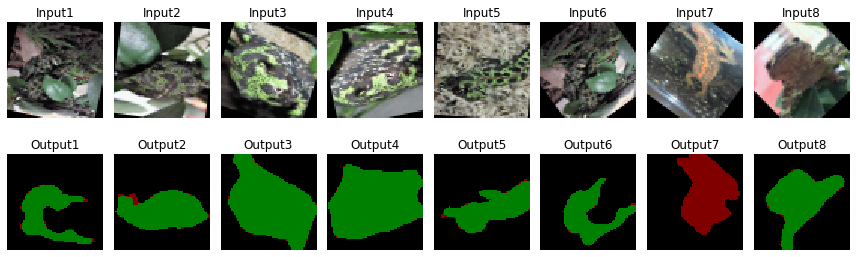

Iter:6550, LossG:0.6636 (fake:0.0000, L1:0.6636), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6600, LossG:0.3709 (fake:0.0000, L1:0.3709), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6600.pt, D >> models/pix2pix_D_iter6600.pt
Iter:6650, LossG:0.3370 (fake:0.0000, L1:0.3370), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6700, LossG:0.3946 (fake:0.0000, L1:0.3946), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6750, LossG:0.3717 (fake:0.0000, L1:0.3717), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6800, LossG:0.3663 (fake:0.0000, L1:0.3663), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6800.pt, D >> models/pix2pix_D_iter6800.pt
Iter:6850, LossG:0.3828 (fake:0.0000, L1:0.3828), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6900, LossG:0.4210 (fake:0.0000, L1:0.4210), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6950, LossG:0.4100 (fake:0.0000, L1:0.4100), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7000, LossG:0.4951 (fake:0.0000, L1:0

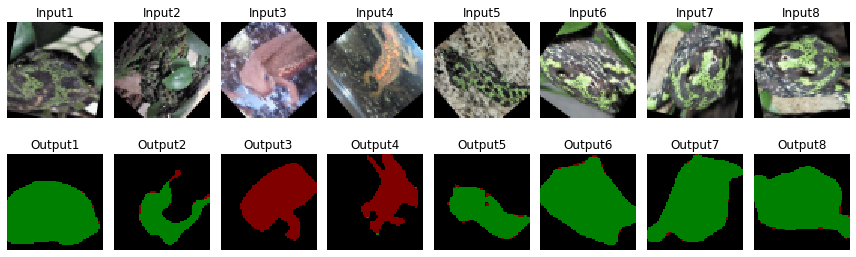

Iter:7050, LossG:0.5023 (fake:0.0000, L1:0.5023), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7100, LossG:0.3764 (fake:0.0000, L1:0.3764), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7150, LossG:0.3993 (fake:0.0000, L1:0.3993), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7200, LossG:0.3016 (fake:0.0000, L1:0.3016), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7200.pt, D >> models/pix2pix_D_iter7200.pt
Iter:7250, LossG:0.3974 (fake:0.0000, L1:0.3974), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7300, LossG:0.3955 (fake:0.0000, L1:0.3955), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7350, LossG:0.3273 (fake:0.0000, L1:0.3273), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7400, LossG:0.4208 (fake:0.0000, L1:0.4208), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7400.pt, D >> models/pix2pix_D_iter7400.pt
Iter:7450, LossG:0.4532 (fake:0.0000, L1:0.4532), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7500, LossG:0.3456 (fake:0.0000, L1:0

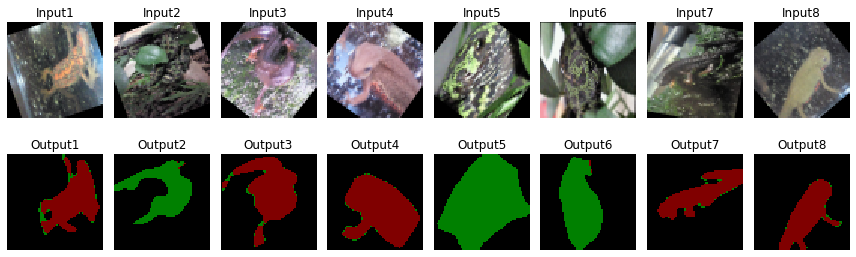

Iter:7550, LossG:0.3799 (fake:0.0000, L1:0.3799), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7600, LossG:0.4479 (fake:0.0000, L1:0.4479), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7600.pt, D >> models/pix2pix_D_iter7600.pt
Iter:7650, LossG:0.4536 (fake:0.0000, L1:0.4536), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7700, LossG:0.8059 (fake:0.0000, L1:0.8059), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7750, LossG:0.3320 (fake:0.0000, L1:0.3320), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7800, LossG:0.3836 (fake:0.0000, L1:0.3836), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7800.pt, D >> models/pix2pix_D_iter7800.pt
Iter:7850, LossG:0.3351 (fake:0.0000, L1:0.3351), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7900, LossG:0.3281 (fake:0.0000, L1:0.3281), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7950, LossG:0.3334 (fake:0.0000, L1:0.3334), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8000, LossG:0.4074 (fake:0.0000, L1:0

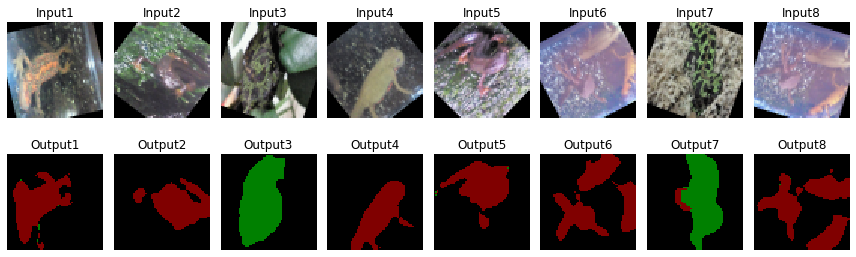

Iter:8050, LossG:0.3778 (fake:0.0000, L1:0.3778), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8100, LossG:0.4111 (fake:0.0000, L1:0.4111), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8150, LossG:0.3672 (fake:0.0000, L1:0.3672), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8200, LossG:0.3158 (fake:0.0000, L1:0.3158), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8200.pt, D >> models/pix2pix_D_iter8200.pt
Iter:8250, LossG:0.4886 (fake:0.0000, L1:0.4886), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8300, LossG:0.3733 (fake:0.0000, L1:0.3733), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8350, LossG:0.3544 (fake:0.0000, L1:0.3544), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8400, LossG:0.3645 (fake:0.0000, L1:0.3645), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8400.pt, D >> models/pix2pix_D_iter8400.pt
Iter:8450, LossG:0.4305 (fake:0.0000, L1:0.4305), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8500, LossG:0.4206 (fake:0.0000, L1:0

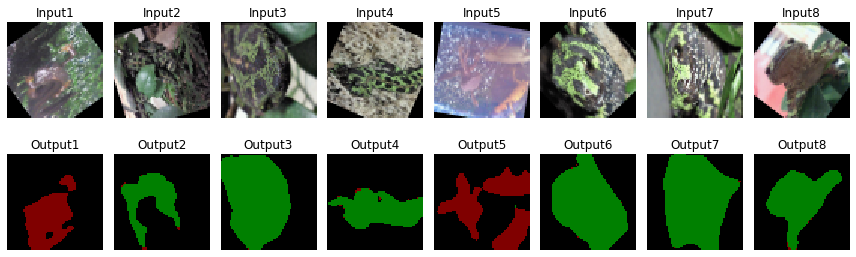

Iter:8550, LossG:0.5272 (fake:0.0000, L1:0.5272), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8600, LossG:0.3709 (fake:0.0000, L1:0.3709), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8600.pt, D >> models/pix2pix_D_iter8600.pt
Iter:8650, LossG:0.3449 (fake:0.0000, L1:0.3449), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8700, LossG:0.3551 (fake:0.0000, L1:0.3551), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8750, LossG:0.3483 (fake:0.0000, L1:0.3483), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8800, LossG:0.3525 (fake:0.0000, L1:0.3525), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8800.pt, D >> models/pix2pix_D_iter8800.pt
Iter:8850, LossG:0.5774 (fake:0.0000, L1:0.5774), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8900, LossG:0.3420 (fake:0.0000, L1:0.3420), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8950, LossG:0.3442 (fake:0.0000, L1:0.3442), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9000, LossG:0.4060 (fake:0.0000, L1:0

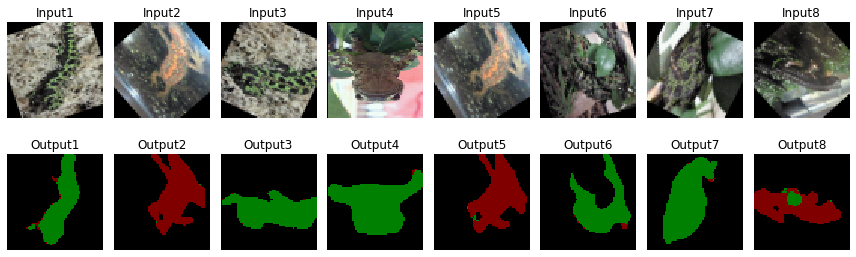

Iter:9050, LossG:0.3132 (fake:0.0000, L1:0.3132), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9100, LossG:0.3113 (fake:0.0000, L1:0.3113), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9150, LossG:0.3338 (fake:0.0000, L1:0.3338), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9200, LossG:0.3772 (fake:0.0000, L1:0.3772), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9200.pt, D >> models/pix2pix_D_iter9200.pt
Iter:9250, LossG:0.4143 (fake:0.0000, L1:0.4143), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9300, LossG:0.2972 (fake:0.0000, L1:0.2972), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9350, LossG:0.3611 (fake:0.0000, L1:0.3611), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9400, LossG:0.4601 (fake:0.0000, L1:0.4601), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9400.pt, D >> models/pix2pix_D_iter9400.pt
Iter:9450, LossG:0.4454 (fake:0.0000, L1:0.4454), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9500, LossG:0.3493 (fake:0.0000, L1:0

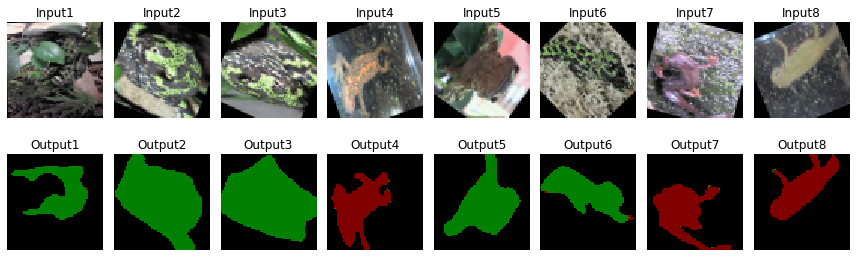

Iter:9550, LossG:0.3974 (fake:0.0000, L1:0.3974), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9600, LossG:0.3550 (fake:0.0000, L1:0.3550), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9600.pt, D >> models/pix2pix_D_iter9600.pt
Iter:9650, LossG:0.3546 (fake:0.0000, L1:0.3546), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9700, LossG:0.3276 (fake:0.0000, L1:0.3276), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9750, LossG:0.3141 (fake:0.0000, L1:0.3141), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9800, LossG:0.3456 (fake:0.0000, L1:0.3456), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9800.pt, D >> models/pix2pix_D_iter9800.pt
Iter:9850, LossG:0.3654 (fake:0.0000, L1:0.3654), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9900, LossG:0.3834 (fake:0.0000, L1:0.3834), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9950, LossG:0.3078 (fake:0.0000, L1:0.3078), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:10000, LossG:0.3296 (fake:0.0000, L1:

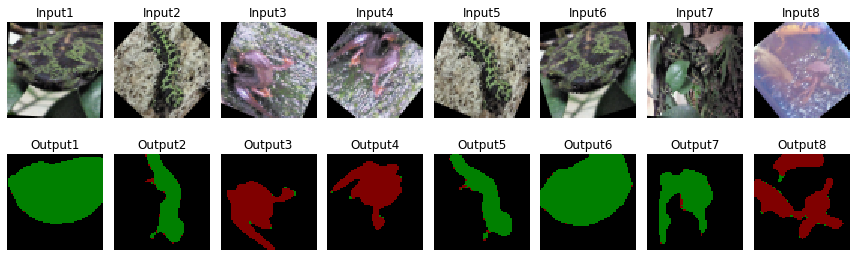

final paramters were saved to G >> models/pix2pix_G_final.pt, D >> models/pix2pix_D_final.pt
loss was saved to >> result/pix2pix_loss.txt


In [10]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    summary(G,(cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(D,(cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH))
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']
    
    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_G_fake= []
    list_loss_G_l1 = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []

    ones = torch.zeros([cfg.TRAIN.MINIBATCH, 1], dtype=torch.float).to(cfg.DEVICE)
    zeros = ones * 0
    
    loss_bce = torch.nn.BCELoss(reduction='mean')
    loss_l1 = torch.nn.L1Loss(reduction='mean')

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        opt_D.zero_grad()

        # sample X
        Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        ys = torch.tensor(get_image(paths_gt[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

        # forward
        Gz = G(Xs)
        loss_D_fake = loss_bce(D(Gz), ones) + loss_bce(D(Xs), ones)
        loss_D_real = loss_bce(D(ys), zeros) + loss_bce(D(Xs), zeros)
        
        # loss backward
        loss_D = loss_D_fake + loss_D_real
        loss_D.backward(retain_graph=True)

        opt_D.step()
            

        # update G
        opt_G.zero_grad()
        loss_G_fake = loss_bce(D(Gz), zeros) + loss_bce(D(Xs), zeros) # fake loss
        loss_G_l1 = cfg.PIX2PIX_LAMBDA * loss_l1(Gz, ys) # L1 loss
        loss_G = loss_G_fake + loss_G_l1
        loss_G.backward()
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_G_fake = loss_G_fake.item()
        _loss_G_l1 = loss_G_l1.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_G_fake.append(_loss_G_fake)
                list_loss_G_l1.append(_loss_G_l1)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG:{:.4f} (fake:{:.4f}, L1:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f})'.format(
                i + 1, _loss_G, _loss_G_fake, _loss_G_l1, _loss_D, _loss_D_real, _loss_D_fake))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_G_fake' : list_loss_G_fake,
                           'loss_G_l1' : list_loss_G_l1, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

In [ ]:
path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
paths = path_dict['paths']
paths_gt = path_dict['paths_gt']

In [ ]:
a = get_image(paths[[0]], cfg, cfg.INPUT_MODE)
plt.imshow(a[0].transpose(1, 2, 0))

In [ ]:
b = get_image(paths_gt[[400]], cfg, cfg.OUTPUT_MODE)
plt.imshow(b[0].transpose(1, 2, 0).astype(np.float))

In [ ]:
b

## Test

In [ ]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(cfg.TEST.ITERATION):
            z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
